In [4]:
%reload_ext autoreload
%autoreload 2

from spice_net import *
from helpers import *

import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Generate the uniform inputs 
num_pts = 40
lh = 2

xs = np.linspace(-lh, lh, num_pts)[:, None]
xs_bias = np.hstack((xs, np.ones(xs.shape)))

### Prelim: uniform inputs and implementing our analytic solver

In [42]:
def gen_A(net: LinearNetwork, all_sources):
    n = len(net.__nodes__[1:])
    # all_sources = np.concatenate((net.inputs, net.outputs))
    m = len(all_sources)
    G = np.zeros((n, n))
    B = np.zeros((n, m))
    C = B.T
    D = np.zeros((m, m))

    # populate G with resistor values
    for R in net.edges:
        i, j = list(map(lambda i: int(i)-1, R.node_names))
        if min(i, j) >= 0:
            G[i, j] = G[j, i] = -1/R.resistance

            G[i, i] += 1/R.resistance
            G[j, j] += 1/R.resistance
        else:
            G[max(i, j), max(i, j)] += 1/R.resistance

    for k, V in enumerate(all_sources):
        i, j = list(map(lambda i: int(i)-1, V.node_names))
        if i >= 0:
            B[i, k] = 1
        if j >= 0:
            B[j, k] = -1

    return np.block([[G, B], [C, D]])

def solve(A, e):
    m = len(e)
    n = len(A) - m

    e = np.reshape(e, (m, -1))
    z = np.concatenate((np.zeros((n, e.shape[1])), e))
    return np.linalg.inv(A) @ z

#### Walk through our method on a toy example

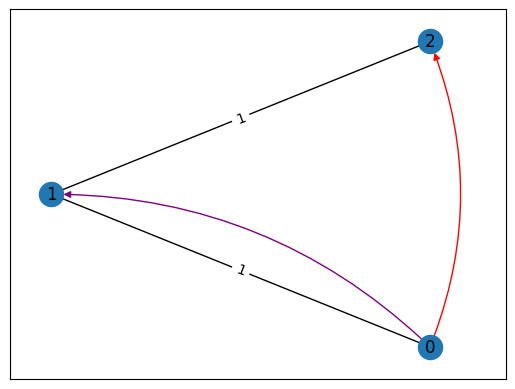

In [43]:
vd_graph = nx.from_numpy_array(np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]))
net = LinearNetwork('voltage_divider', con_graph=vd_graph, node_cfg=(np.array([[2, 0]]), np.array([[1, 0]])), epsilon=1e-16)
visualize(net)

In [44]:
A = gen_A(net, net.inputs)

In [45]:
np.linalg.eigvals(A), np.linalg.det(A)

(array([ 2.73205081,  1.        , -0.73205081]), -2.0)

In [46]:
print(A)

[[ 2. -1.  0.]
 [-1.  1.  1.]
 [ 0.  1.  0.]]


In [47]:
# view our computed voltages compared to SPICE-generated solutions
# NOTE: first node is defined as ground and is implicitly left out. last node represents current through the voltage source.
x = solve(A, [1]) 
x

array([[ 0.5],
       [ 1. ],
       [-0.5]])

In [48]:
net.solve([1]).squeeze()

array([0. , 0.5, 1. ])

#### Test our method against SPICE on many random graphs

In [50]:
# test our implementation on lots of examples
num_examples = 10000
for _ in range(num_examples):
    n = np.random.randint(4, 10)
    k  = np.random.randint(1, n)
    p = 0.5 + (np.random.random()/2)

    in_nodes = out_nodes = 1
    con_graph = nx.erdos_renyi_graph(n=n, p=p, directed=False)
    while not nx.is_connected(con_graph):
        con_graph = nx.erdos_renyi_graph(n=n, p=p, directed=False)

    for u, v in con_graph.edges():
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = np.abs(np.random.normal(1, 0.5))


    node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(n-in_nodes-out_nodes-1))
    node_cfg = np.random.choice(n, size=(in_nodes + out_nodes, 2), replace=False)
    node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

    net = LinearNetwork('test', con_graph, node_cfg)

    A = gen_A(net, net.inputs)
    v_in = np.random.randn(1)

    spice_sol = net.solve(v_in).squeeze()[1:]
    our_sol = solve(A, v_in).squeeze()[:-1]

    assert np.allclose(our_sol, spice_sol), (our_sol, spice_sol)

### 

In [135]:
# Fixed parameters
nodes = 8
edge_prob = .5

in_nodes = 2
out_nodes = 1

num_trials = 50000

In [136]:
slope_vals = []
intercept_vals = []

coeff = np.linalg.inv(xs_bias.T @ xs_bias) @ xs_bias.T

In [137]:
con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
for i, (u, v) in enumerate(con_graph.edges()):
    con_graph[u][v]['type'] = 'resistor'

node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

out_plus = node_cfg[1][0][0]
out_minus = node_cfg[1][0][1]

In [138]:
for _ in range(num_trials):
    weights = np.abs(np.random.normal(1, 0.5, size=con_graph.number_of_edges()))

    for i, (u, v) in enumerate(con_graph.edges()):
        con_graph[u][v]['weight'] = weights[i]

    net = LinearNetwork('test', con_graph, node_cfg)

    A = gen_A(net, net.inputs)
    sol = solve(A, xs_bias.T)
    sol_plus = sol[out_plus-1] if out_plus > 0 else np.zeros(sol[out_plus].shape)
    sol_minus = sol[out_minus-1] if out_minus > 0 else np.zeros(sol[out_minus].shape)
    preds = sol_plus - sol_minus

    # preds = net.predict(xs_bias).squeeze()

    slope, intercept = coeff @ preds


    slope_vals.append(slope)
    intercept_vals.append(intercept)


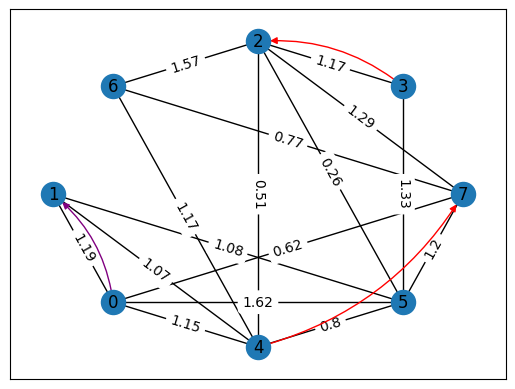

In [139]:
visualize(net)

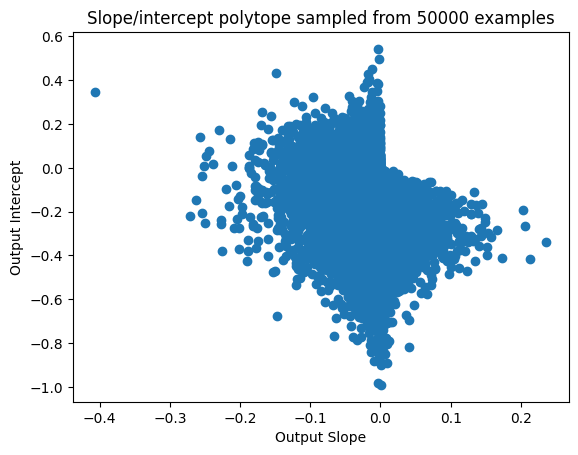

In [141]:
plt.scatter(slope_vals, intercept_vals)
plt.title(f'Slope/intercept polytope sampled from {len(slope_vals)} examples')
plt.xlabel('Output Slope')
plt.ylabel('Output Intercept')
# plt.plot(np.arange(-1, 1, 0.1), 1-np.abs(np.arange(-1, 1, 0.1)), 'r', alpha=0.5)
# plt.plot(np.arange(-1, 1, 0.1), -1+np.abs(np.arange(-1, 1, 0.1)), 'r', alpha=0.5)
plt.show()